In [214]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [216]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [217]:
weight_scale = 1.0
g = 0.25

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 10.0
delay_std = delay_mean * 0.4
v_ext = 0.5

excitatory_type = "ss4"
inhibitory_type = "b"

## Generate network

In [218]:
G = nx.DiGraph()

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(1000), 800)
for i in range(800):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(800, 1000):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw m outgoing edges to random nodes
n_out = 150
for i in range(1000):
    targets = random.sample(range(1000), n_out)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
            delay = max(0.1, np.random.normal(3.0, 1.0))
        else:
            weight = J_E
            delay = max(0.1, np.random.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

In [219]:
# Redistribute lognormally
G = assign_lognormal_weights_for_ntype(G, "ss4", mu=-1.5, sigma=0.85, w_max=10.0)

Text(0.5, 1.0, 'ss4 Weight Distribution after Lognormal Redistribution')

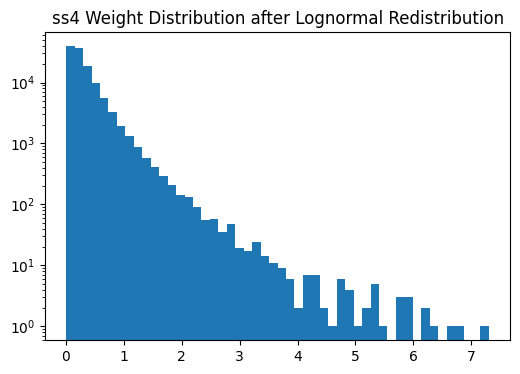

In [220]:
# Plot ss4 weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == 'ss4']
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title("ss4 Weight Distribution after Lognormal Redistribution")

## Simulation setup

In [221]:
dt = 0.1

In [222]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [223]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [224]:
nmda_weight = np.ones(connectome.neuron_population.n_neurons, dtype=float)
nmda_weight[pop.inhibitory_mask.astype(bool)] = 0.0
# Invert to make excitatory neurons have NMDA weight 1, inhibitory 0
# nmda_weight

## Simulation

100%|██████████| 15000/15000 [00:15<00:00, 955.13it/s] 


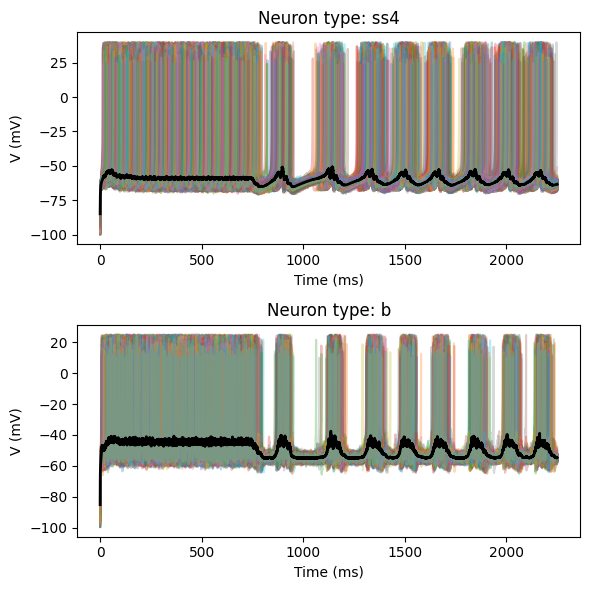

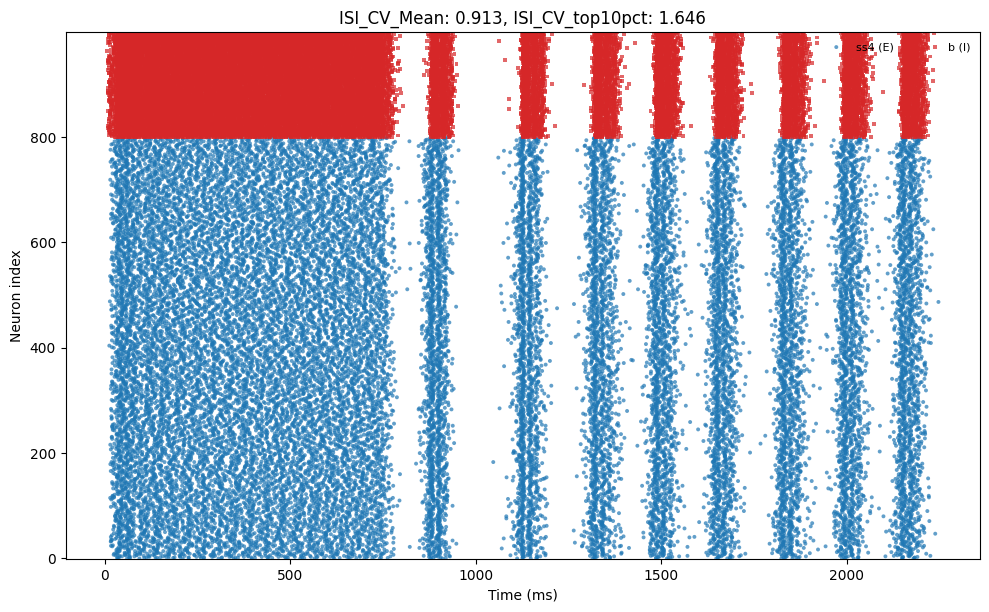

In [225]:

# Randomize initial voltages
Vs = np.random.uniform(-100, -70, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0, "NMDA_weight": nmda_weight}, rise_synapse=True,
                 enable_debug_logger=True)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=1.0)

from tqdm import tqdm

for i in tqdm(range(7500)):
    sensory_spikes = poisson(dt)
    sim.step(spike_ext=sensory_spikes)
    # sim.step()

for i in tqdm(range(15000)):
    sim.step()

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=3000.0)

In [226]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=750.0, t_stop_ms=2250.0)

{'rate_mean_Hz': 14.574361709219385,
 'rate_median_Hz': 11.332577828144789,
 'rate_p95_Hz': 31.331244583694417,
 'ISI_CV_median': 0.7347505743062426,
 'ISI_CV_mean': 0.83912244819269,
 'ISI_CV_mean_E': 0.7040639978486279,
 'ISI_CV_mean_I': 1.3793562495689378,
 'ISI_CV_mean_top10pct': 1.4446679174478922,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_2ms': 0.9786381842456635,
 'Fano_median_10ms': 0.8926174496644321,
 'Fano_median_50ms': 0.7586206896551723,
 'Fano_median_100ms': 0.5982142857142858,
 'Fano_median_300ms': 0.21874999999999997,
 'Fano_median_500ms': 0.25000000000000006,
 'Fano_median_1000ms': 0.0,
 'mean_noise_corr_2ms': 0.04322898242984744,
 'mean_noise_corr_10ms': 0.22926307904198412,
 'mean_noise_corr_50ms': 0.7003782441029174,
 'mean_noise_corr_100ms': 0.7033478703278706,
 'mean_noise_corr_300ms': 0.6467109638912159,
 'mean_noise_corr_500ms': 0.9325203636508796,
 'mean_noise_corr_1000ms': 0.0,
 'participation_frac_mean_300ms': 1.0,
 'participation_frac_median_30

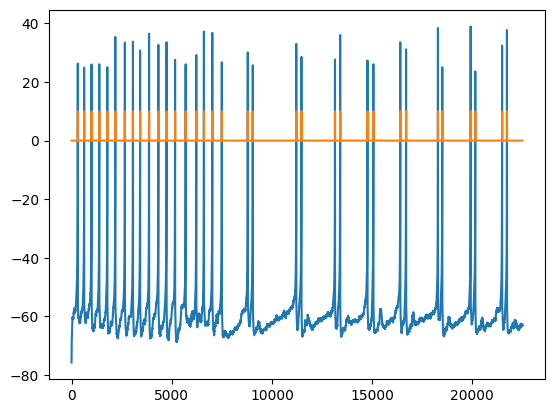

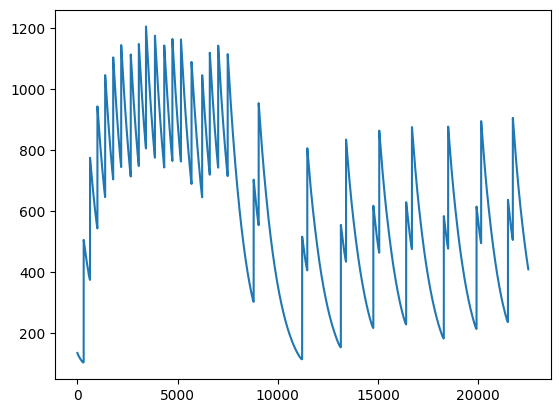

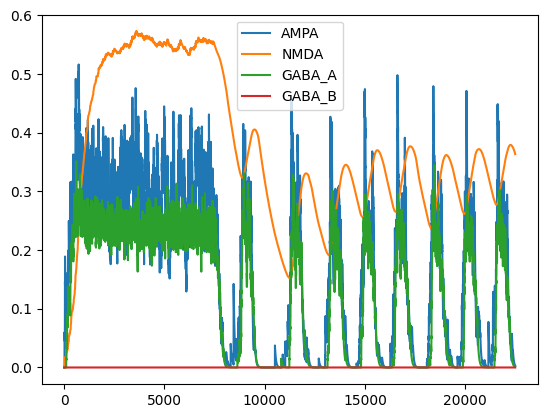

In [227]:
# Plot spikes for one neuron
n_idx = 707
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

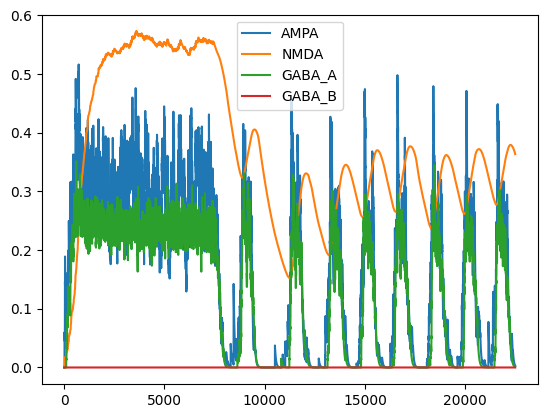

In [228]:
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

In [229]:
# connectome.compute_metrics(small_world=False)